## **Imports**

In [1]:
import sys, os, warnings
from os import listdir

path2add = os.path.normpath(os.path.abspath(os.path.join(os.path.dirname('__file__'), os.path.pardir, 'utils')))
if (not (path2add in sys.path)) :
    sys.path.append(path2add)

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from pmdarima.arima import auto_arima
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler
import itertools


from model_utils import time_series_analysis
from model_utils import time_series_analysis_dataframe
from model_utils import acf_pacf_test
from model_utils import ar_baseline_model
from model_utils import arima_model
from model_utils import sarimax_model
from model_utils import prophet_model
from model_utils import lstm_implementation_pipeline
from model_utils import lstm_multivariate_implementation_pipeline
from model_utils import anomaly_detector
from model_utils import save_model

sns.set_palette("crest")

pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

## **Data Loading**

In [2]:
all_paths = []
fol_name = r"C:\Users\angel\Desktop\Data Analysis\Ironhack\Final Bootcamp Project\Smart-Home-Energy-Consumption-Project\data"
for e in os.listdir(fol_name):
    full = os.path.join(fol_name, e)
    if os.path.isfile(full):
        all_paths.append(full)

data = pd.concat(pd.read_csv(f, low_memory=False) for f in all_paths)
data["time"] = pd.to_datetime(data["time"])
data = data.set_index('time').drop(columns="Unnamed: 0", axis=1)
display(data.head())

,use,gen,dishwasher,home office,fridge,wine cellar,garage door,barn,well,microwave,living room,temperature,humidity,visibility,apparenttemperature,pressure,windspeed,cloudcover,windbearing,precipintensity,dewpoint,precipprobability,furnace,kitchen,month,day,weekday,hour,minute
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01 05:00:00,0.932833,0.003483,0.000033,0.442633,0.124150,0.006983,0.013083,0.031350,0.001017,0.004067,0.001517,36.14,0.62,10.0,29.26,1016.91,9.18,0.75,282.0,0.0,24.4,0.0,0.082617,0.000567,1,1,Friday,5,0
2016-01-01 05:01:00,0.934333,0.003467,0.000000,0.444067,0.124000,0.006983,0.013117,0.031500,0.001017,0.004067,0.001650,36.14,0.62,10.0,29.26,1016.91,9.18,0.75,282.0,0.0,24.4,0.0,0.084533,0.000567,1,1,Friday,5,1
2016-01-01 05:02:00,0.931817,0.003467,0.000017,0.446067,0.123533,0.006983,0.013083,0.031517,0.001000,0.004067,0.001650,36.14,0.62,10.0,29.26,1016.91,9.18,0.75,282.0,0.0,24.4,0.0,0.083017,0.000617,1,1,Friday,5,2
2016-01-01 05:03:00,1.022050,0.003483,0.000017,0.446583,0.123133,0.006983,0.013000,0.031500,0.001017,0.004067,0.001617,36.14,0.62,10.0,29.26,1016.91,9.18,0.75,282.0,0.0,24.4,0.0,0.175417,0.000650,1,1,Friday,5,3
2016-01-01 05:04:00,1.139400,0.003467,0.000133,0.446533,0.122850,0.006850,0.012783,0.031500,0.001017,0.004067,0.001583,36.14,0.62,10.0,29.26,1016.91,9.18,0.75,282.0,0.0,24.4,0.0,0.300917,0.000783,1,1,Friday,5,4


## **Univariate Time-Series Prediction**

### *Stationarity and Seasonality*

>##### **Starting point**
>Before implementing a baseline model, I need to verify whether the "use" column meets certain conditions. Models like ARIMA works better with stationary data, meaning constant mean and standard deviation without seasonality. 
>
>##### **Impact**
>
>To assess this, I will visually inspect the plotted column and conduct statistical tests such as the Augmented Dickey-Fuller (ADF) test and seasonal decomposition.

In [3]:
use_data_daily = data["use"].resample("D").mean() # I will resample the values by grouping them into diferent intervals 
use_data_weekly = data["use"].resample("W").mean()
use_data_hourly = data["use"].resample("H").mean()

train_data_daily, test_data_daily = train_test_split(use_data_daily, test_size=0.2, shuffle=False)
train_data_hourly, test_data_hourly = train_test_split(use_data_hourly,test_size = 0.2, shuffle=False)

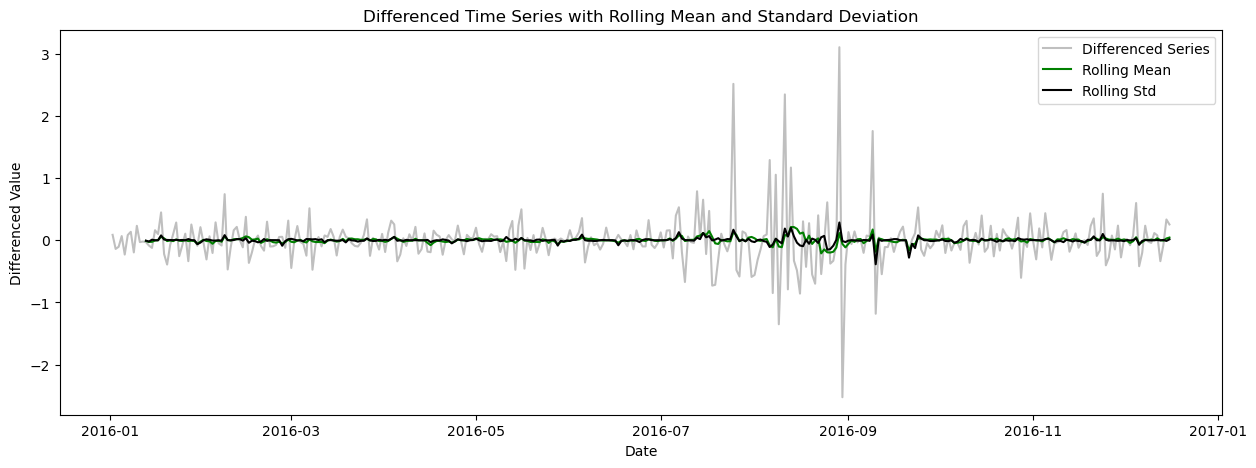

<Figure size 640x480 with 0 Axes>

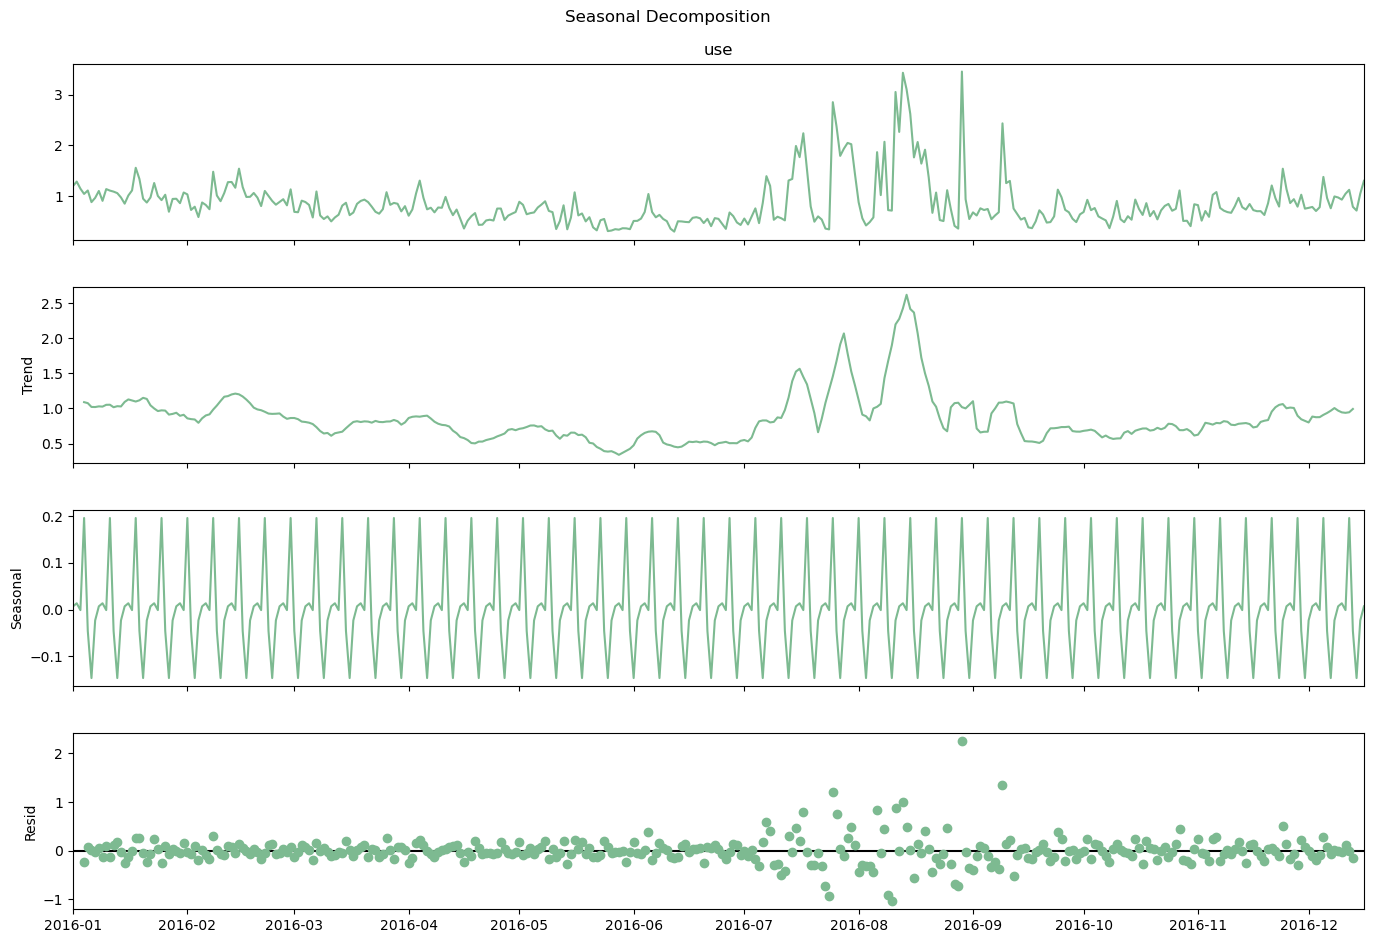

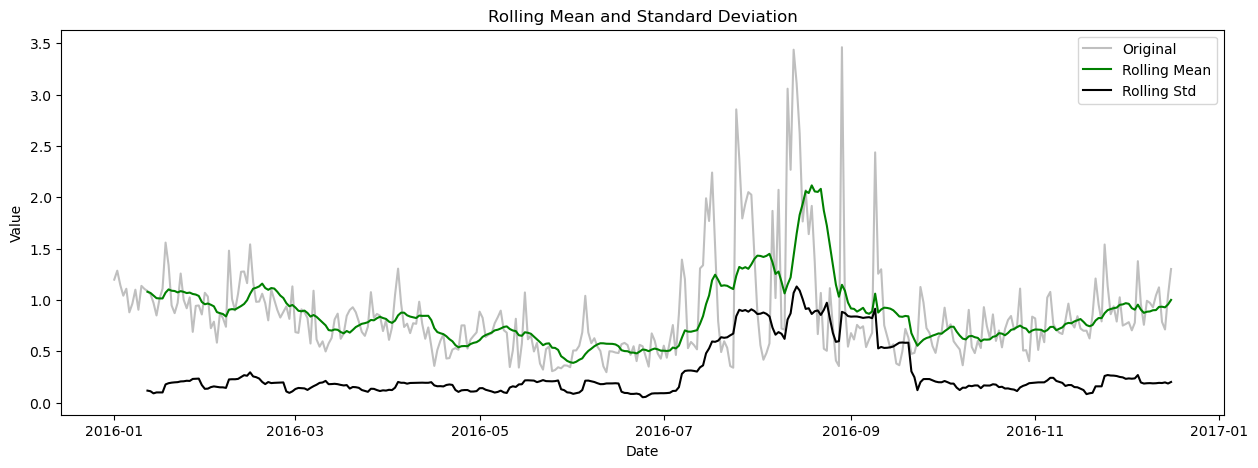

The time series is stationary (reject the null hypothesis)


,ADF Test
ADF Statistic,-2.988003
p-value,0.036030
Critical Value (1%),-3.449730
Critical Value (5%),-2.870079
Critical Value (10%),-2.571319


In [4]:
time_series_analysis(use_data_daily)

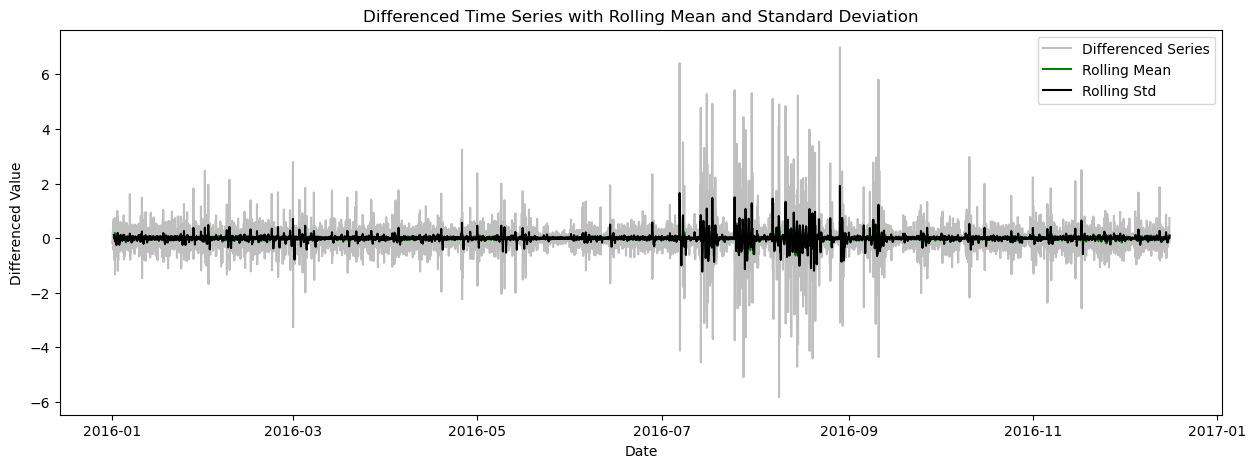

<Figure size 640x480 with 0 Axes>

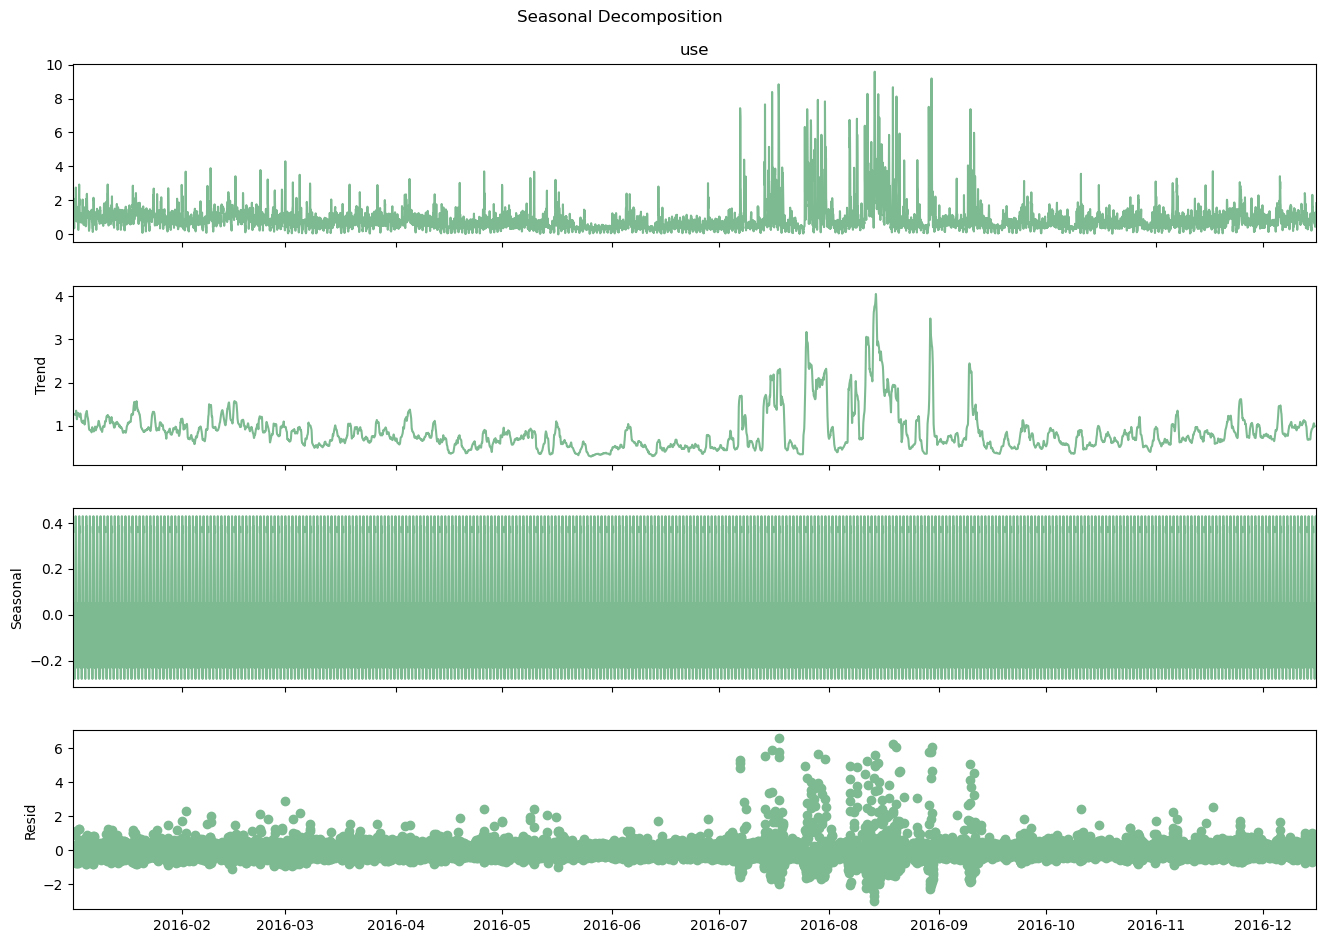

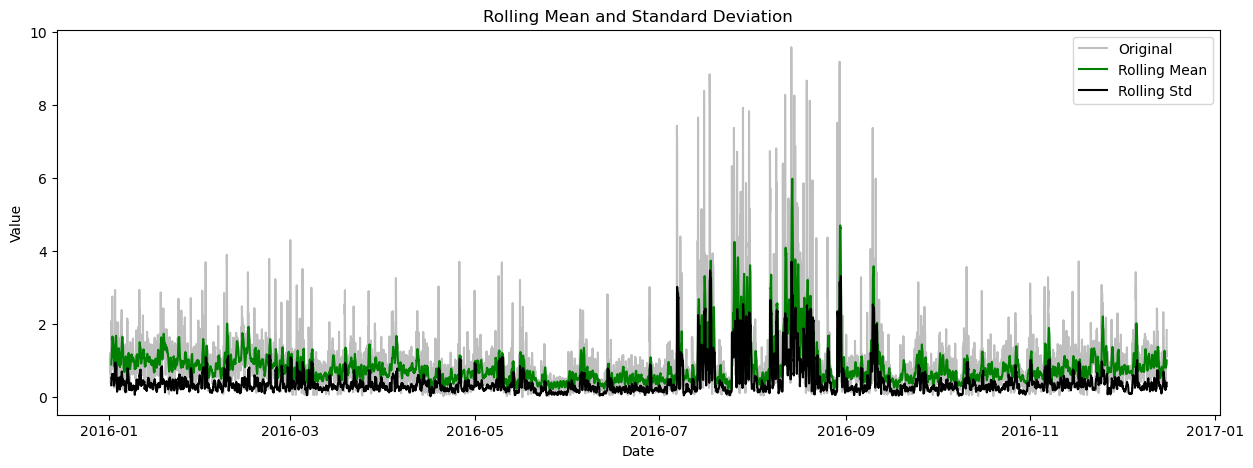

The time series is stationary (reject the null hypothesis)


,ADF Test
ADF Statistic,-8.716818e+00
p-value,3.470341e-14
Critical Value (1%),-3.431131e+00
Critical Value (5%),-2.861885e+00
Critical Value (10%),-2.566954e+00


In [5]:
time_series_analysis(use_data_hourly)

>##### **Observations**
>
>* Given that we only have data for a year, it's difficult to ascertain whether seasonality applies to months or yearly seasons. However, the residual component and trend of the seasonal decomposition test suggest the possibility of seasonality, particularly during summer months. Nonetheless, the test captures some weekly seasonality within the year. 
>* The results of the Augmented Dickey-Fuller (ADF) test indicate with a 95% confidence level that the data is indeed stationary. Hence, autoregressive models can be successfully applied and no transformation is needed over the data to do so.
>* The increase in mean and specially in standard deviation during summer months again indicates the presence of anomalous consumption behaviors.
>
>##### **Impact**
>
>* I will proceed to implement an autoregressive model to establish baseline metrics for further improvement.
>* Even though I cannot ascertain seasonality over years, I will maintain the slight assumption that there is a relevant seasonal component. I will delve deeper into this during subsequent steps, especially when regressors and multivariate modeling is introduced.

### *Auto Regressive Baseline model*

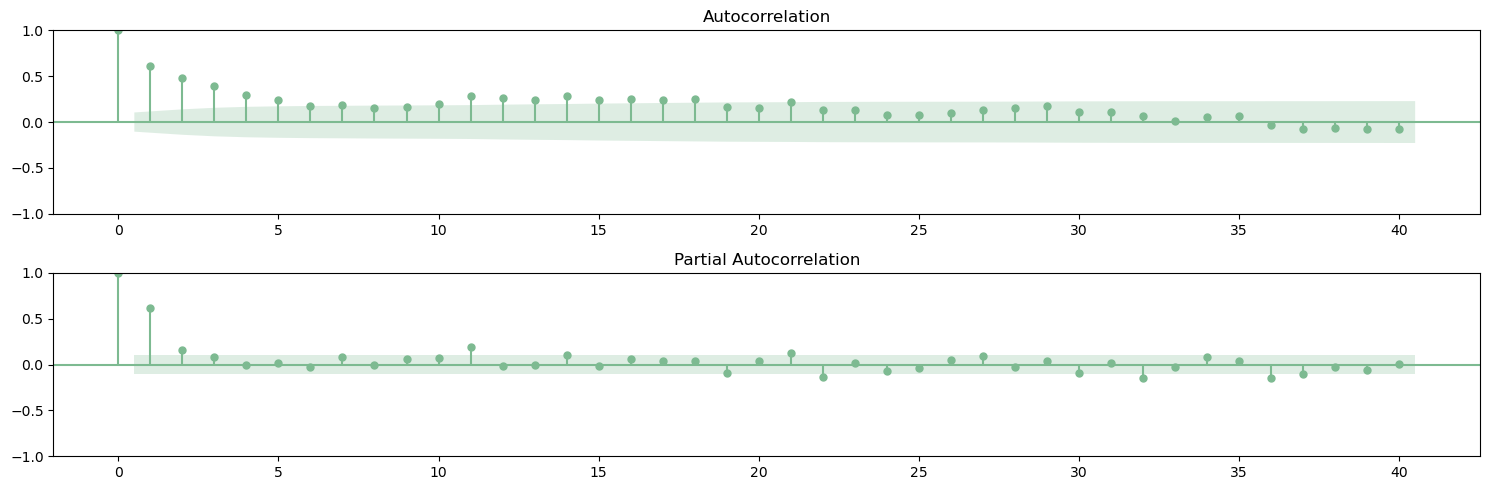

In [6]:
acf_pacf_test(use_data_daily)

> * Based on the Partial Autocorrelation Function (PACF) results, it's evident that lags 1, 2, and 11 exhibit significant correlation for daily data. Therefore, I will utilize them as the AR parameters.

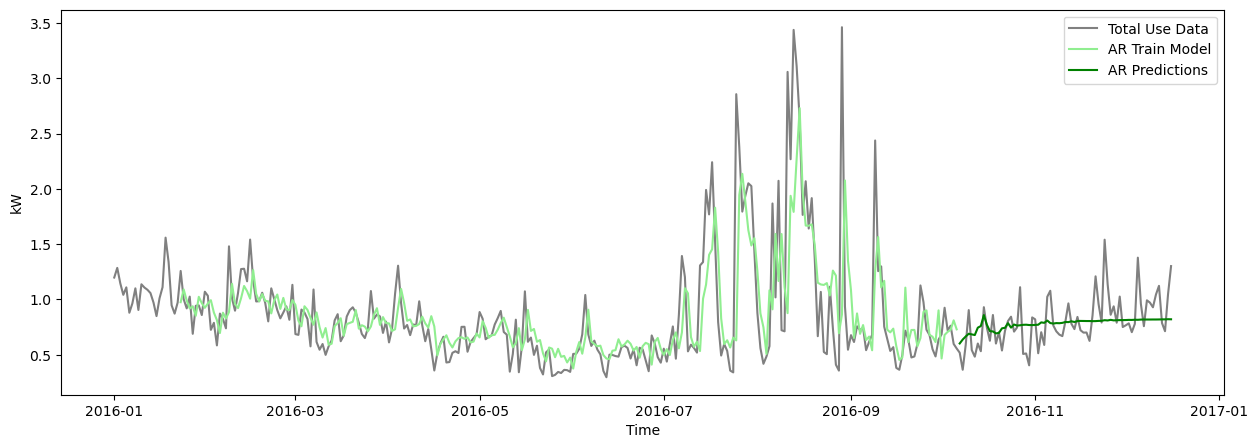

                            AutoReg Model Results                             
Dep. Variable:                    use   No. Observations:                  280
Model:             Restr. AutoReg(22)   Log Likelihood                -125.576
Method:               Conditional MLE   S.D. of innovations              0.394
Date:                Fri, 10 May 2024   AIC                            265.153
Time:                        19:00:28   BIC                            290.023
Sample:                    01-23-2016   HQIC                           275.153
                         - 10-06-2016                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1276      0.068      1.884      0.060      -0.005       0.260
use.L1         0.5076      0.060      8.499      0.000       0.391       0.625
use.L2         0.1422      0.059      2.401      0.0

,R2,MAE,MAPE,MSE,RMSE
0,0.171559,0.150114,19.274716,0.040668,0.201664


In [7]:
ar_daily_model, ar_daily_metrics = ar_baseline_model(train_data_daily, test_data_daily, use_data_daily, lags=[1,2,11,21,22], trend="c")
ar_daily_metrics

>##### **Observations** 
> * We observe that the AR model, in its simplicity, exhibits poor predictive performance with lags 1, 2, 11, 21, and 22. The p-value of each lag indicates that they offer good statistical significance to the model, but while the errors aren't that bad, there is much room for improvement in predictions. While we could marginally enhance these metrics by incorporating additional lags, I opt against doing so, as it would only increase the complexity of the model without substantially improving its fit.
>
> ##### **Impact**
> * Let's see how it behaves by implementing the moving average component and by ussing the transformed data. To help the selection of values for this parameters i will plot the residuals of the predictions 

### *ARIMA model*

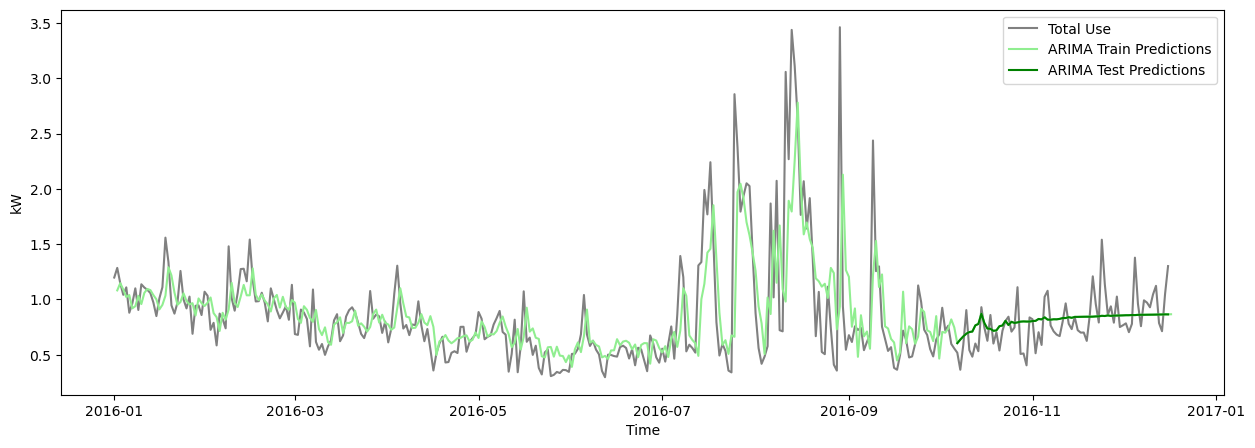

                                        SARIMAX Results                                         
Dep. Variable:                                      use   No. Observations:                  280
Model:             ARIMA([1, 2, 11, 21, 22], 0, [2, 6])   Log Likelihood                -126.929
Date:                                  Fri, 10 May 2024   AIC                            271.857
Time:                                          19:00:29   BIC                            304.570
Sample:                                      01-01-2016   HQIC                           284.979
                                           - 10-06-2016                                         
Covariance Type:                                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8751      0.242      3.616      0.000       0.401

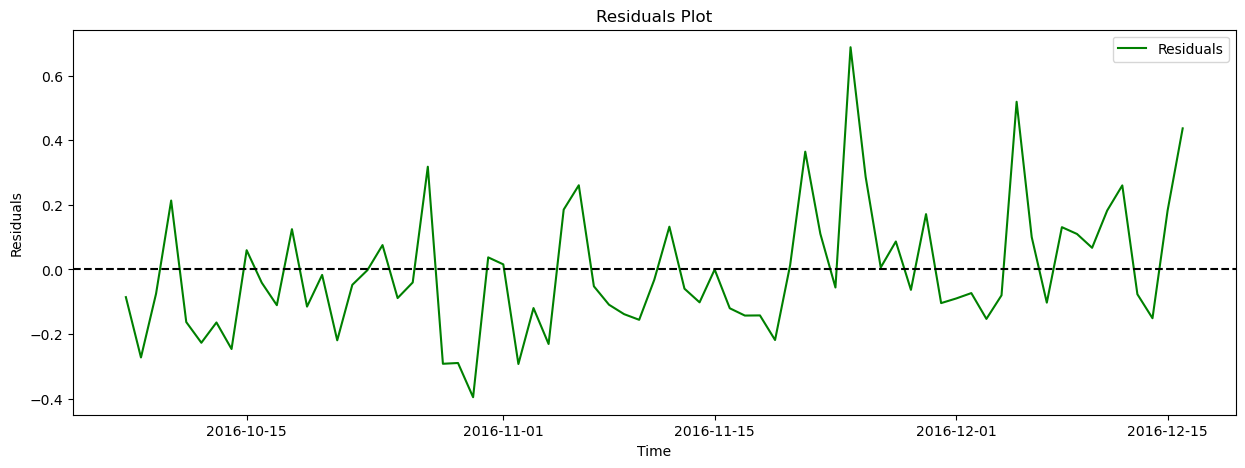

,R2,MAE,MAPE,MSE,RMSE
0,0.205871,0.153577,20.511421,0.038984,0.197444


In [8]:
arima,arima_metrics,arima_residuals = arima_model(train_data_daily,test_data_daily, use_data_daily,order=((1,2,11,21,22),0,(2,6)))
arima_metrics

> * Based on the p-values of the lags, there is no significant improvement in the model fitting with the moving average component. Nevertheless, the prediction power seems to improve slightly. Additionaly,there is no recognizable pattern in the residual plot.

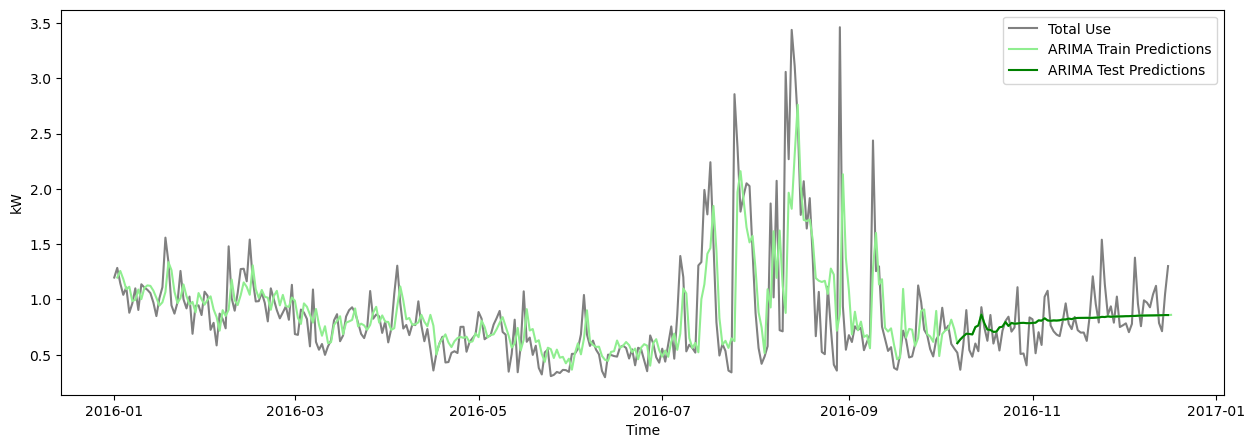

                                      SARIMAX Results                                      
Dep. Variable:                                 use   No. Observations:                  280
Model:             ARIMA([1, 2, 11, 21, 22], 1, 1)   Log Likelihood                -128.966
Date:                             Fri, 10 May 2024   AIC                            271.932
Time:                                     19:00:30   BIC                            297.350
Sample:                                 01-01-2016   HQIC                           282.128
                                      - 10-06-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5150      0.047     10.907      0.000       0.422       0.608
ar.L2          0.1447      

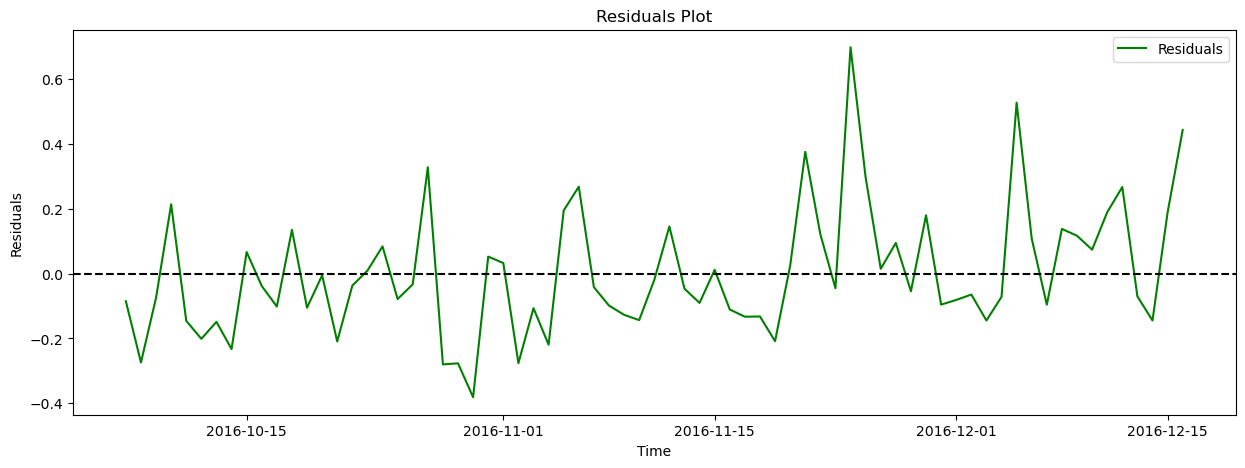

,R2,MAE,MAPE,MSE,RMSE
0,0.216516,0.151115,19.927127,0.038461,0.196116


In [9]:
arima,arima_metrics,arima_residuals = arima_model(train_data_daily,test_data_daily, use_data_daily, order=((1,2,11,21,22),1,(1)))
arima_metrics

> * There are no significant improvements from implementing a difference transformation to the data, apart from a slight improvement in prediction metrics. Based on the plots, we can see that the model is not capturing the underlying patterns of consumption. After abandoning this model, let's proceed with wrapped parameter tuning. I will explore potential seasonality possibilities and incorporate them into a seasonal ARIMA model.

In [10]:
#auto_arima = auto_arima(train_data_daily, start_p=0, d=0, start_q=0, max_p=11, max_d=1, max_q=11,
                       # start_P=0, D=1, start_Q=0, max_P=11, max_D=1, max_Q=11, m=12, 
                       # seasonal=True, trace=True,stepwise=True)

#(1,0,1)(8,1,0)[12]

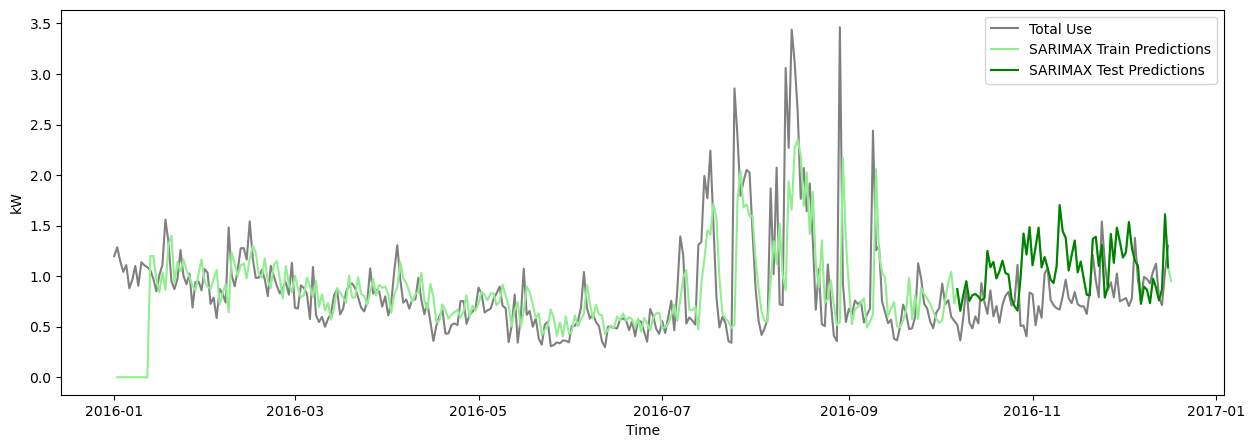

                                      SARIMAX Results                                      
Dep. Variable:                                 use   No. Observations:                  280
Model:             SARIMAX(1, 0, 1)x(8, 1, [], 12)   Log Likelihood                -156.741
Date:                             Fri, 10 May 2024   AIC                            335.481
Time:                                     19:00:57   BIC                            374.982
Sample:                                 01-01-2016   HQIC                           351.347
                                      - 10-06-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8065      0.046     17.543      0.000       0.716       0.897
ma.L1         -0.2998      

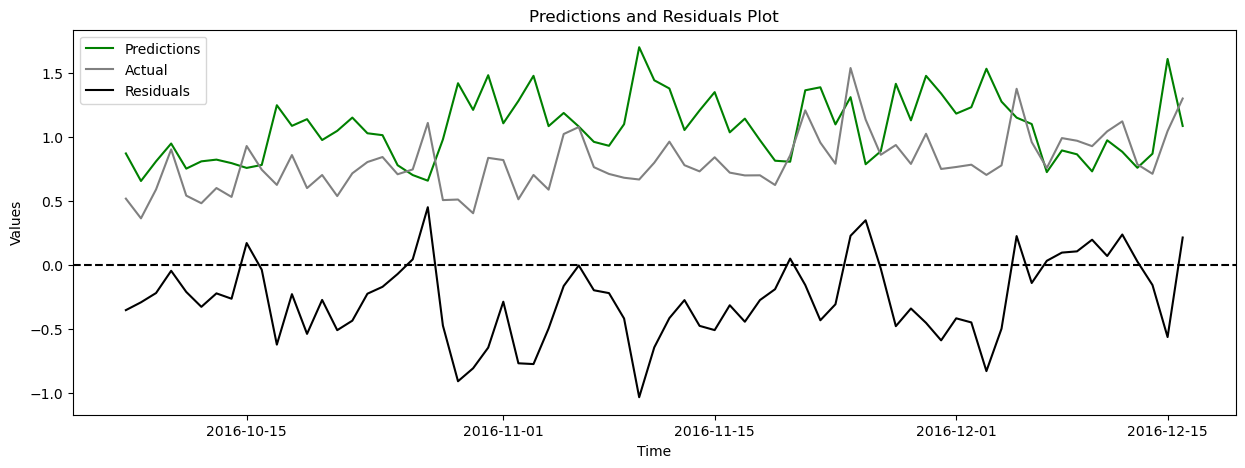

,R2,MAE,MAPE,MSE,RMSE
0,-2.432094,0.340263,48.786586,0.168482,0.410466


In [11]:
sarimax,sarimax_metrics = sarimax_model(train_data_daily, test_data_daily, use_data_daily, order=(1,0,1),seasonal_order=(8,1,0,12))
sarimax_metrics

> * The seasonal model demonstrates a satisfactory fit to the data, with notable coefficients for both autoregressive and moving average terms, along with seasonal terms at lags 12, 24, 36, 48, and 60. Based on the enlarged prediction plot, it seems to capture some of the patterns of the data. However, despite this, its predictive performance for future values is quite poor.


### *Prophet*

> Prophet is a forecasting tool developed by Facebook that is designed to handle time series data with strong seasonal effects and irregular trends. It models time series data as a combination of three main components: **trend**, **seasonality**, and **holidays**. The trend component captures the long-term direction of the data, while the seasonality component models periodic fluctuations, such as daily, weekly, or yearly patterns. Additionally, Prophet allows for the incorporation of custom seasonalities, such as those based on external factors like weather conditions.
>
>I have chosen to use Prophet to incorporate **meteorological variables** and some indicators of seasonality, such as **hours or days of the week**, as regressors. This decision is based on Prophet's flexibility in handling multiple regressors and its ability to capture complex seasonal patterns, making it suitable for modeling consumption data influenced by both weather variations and time-based trends.

#### *Stationarity of regressors*

> * First, I'll check for stationarity in the columns I may use as regressors, similar to what was done before for the "use" column.

In [12]:
new_data = pd.DataFrame(data["use"])
added_vars = pd.DataFrame(data[["visibility","pressure",'temperature',"precipprobability", 'humidity','windspeed', 
                                'cloudcover', 'windbearing', 'precipintensity','dewpoint',"hour","month","day","weekday"]])

added_vars = pd.get_dummies(added_vars, columns=['weekday'], prefix='weekday')
new_data = pd.concat([new_data, added_vars], axis=1)

new_data_resampled = new_data.resample("d").mean()
time_series_analysis_dataframe(new_data_resampled)

The time series in column 'use' is stationary (reject the null hypothesis)
The time series in column 'visibility' is stationary (reject the null hypothesis)
The time series in column 'pressure' is stationary (reject the null hypothesis)
The time series in column 'temperature' is not stationary (cannot reject the null hypothesis)
The time series in column 'precipprobability' is stationary (reject the null hypothesis)
The time series in column 'humidity' is stationary (reject the null hypothesis)
The time series in column 'windspeed' is stationary (reject the null hypothesis)
The time series in column 'cloudcover' is stationary (reject the null hypothesis)
The time series in column 'windbearing' is stationary (reject the null hypothesis)
The time series in column 'precipintensity' is stationary (reject the null hypothesis)
The time series in column 'dewpoint' is not stationary (cannot reject the null hypothesis)
The time series in column 'hour' is stationary (reject the null hypothesis)


,ADF Statistic,p-value,Critical Value (1%),Critical Value (5%),Critical Value (10%),Stationary
use,-2.988003e+00,3.603009e-02,-3.449730,-2.870079,-2.571319,True
visibility,-6.618033e+00,6.136499e-09,-3.449392,-2.869930,-2.571240,True
pressure,-6.622345e+00,5.993197e-09,-3.449392,-2.869930,-2.571240,True
temperature,-1.020157e+00,7.458416e-01,-3.450022,-2.870207,-2.571387,False
precipprobability,-1.146377e+01,5.473803e-21,-3.449282,-2.869881,-2.571214,True
humidity,-4.583407e+00,1.385783e-04,-3.449447,-2.869954,-2.571253,True
windspeed,-1.358513e+01,2.087548e-25,-3.449173,-2.869833,-2.571188,True
cloudcover,-7.254754e+00,1.742586e-10,-3.449337,-2.869906,-2.571227,True
windbearing,-1.224495e+01,9.831625e-23,-3.449173,-2.869833,-2.571188,True
precipintensity,-1.176596e+01,1.118898e-21,-3.449282,-2.869881,-2.571214,True


> **Observations**
>
>* For an hourly resampling, the column "month" is not stationary.
>* For a daily resampling, the column "months", "dewpoint" and "temperature" are not stationary.
>
> **Impact**
>
>* I will drop those columns from the list of regressors inserted into each prophet model.

In [13]:
transformed_data_daily = data.select_dtypes("number").resample("d").mean()#.applymap(lambda x: np.log(x) if x > 0 else 0)
transformed_data_hourly = data.select_dtypes("number").resample("h").mean()#.applymap(lambda x: np.log(x) if x > 0 else 0)

daily_regressors = ["visibility","pressure","precipprobability",'humidity','windspeed', 
                    'cloudcover', 'windbearing', 'precipintensity',"hour","day"]
hourly_regressors = ["visibility","pressure","precipprobability",'humidity','windspeed', 
                     'cloudcover', 'windbearing', 'precipintensity',"hour","day", "temperature", "dewpoint"]


19:00:58 - cmdstanpy - INFO - Chain [1] start processing
19:00:58 - cmdstanpy - INFO - Chain [1] done processing


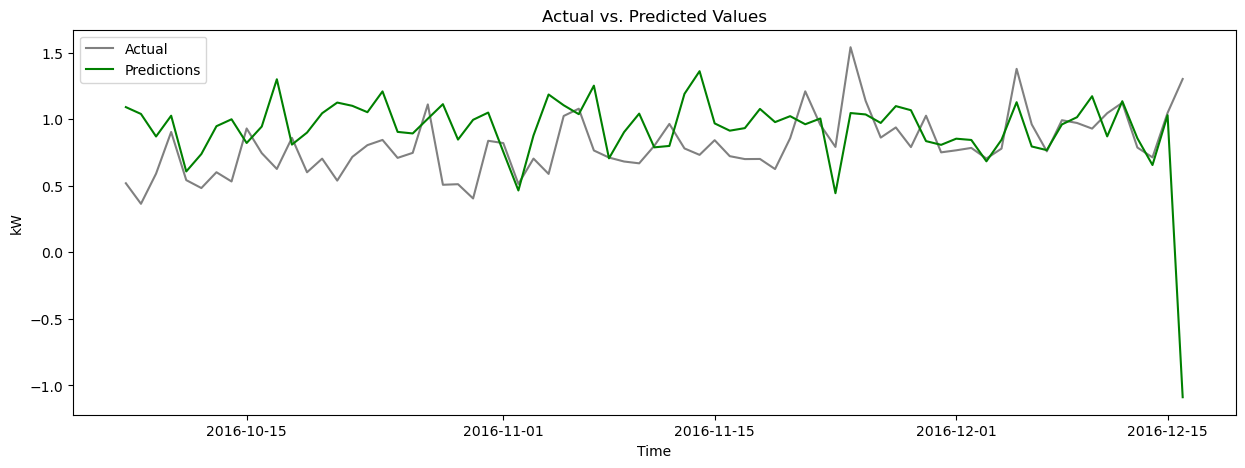

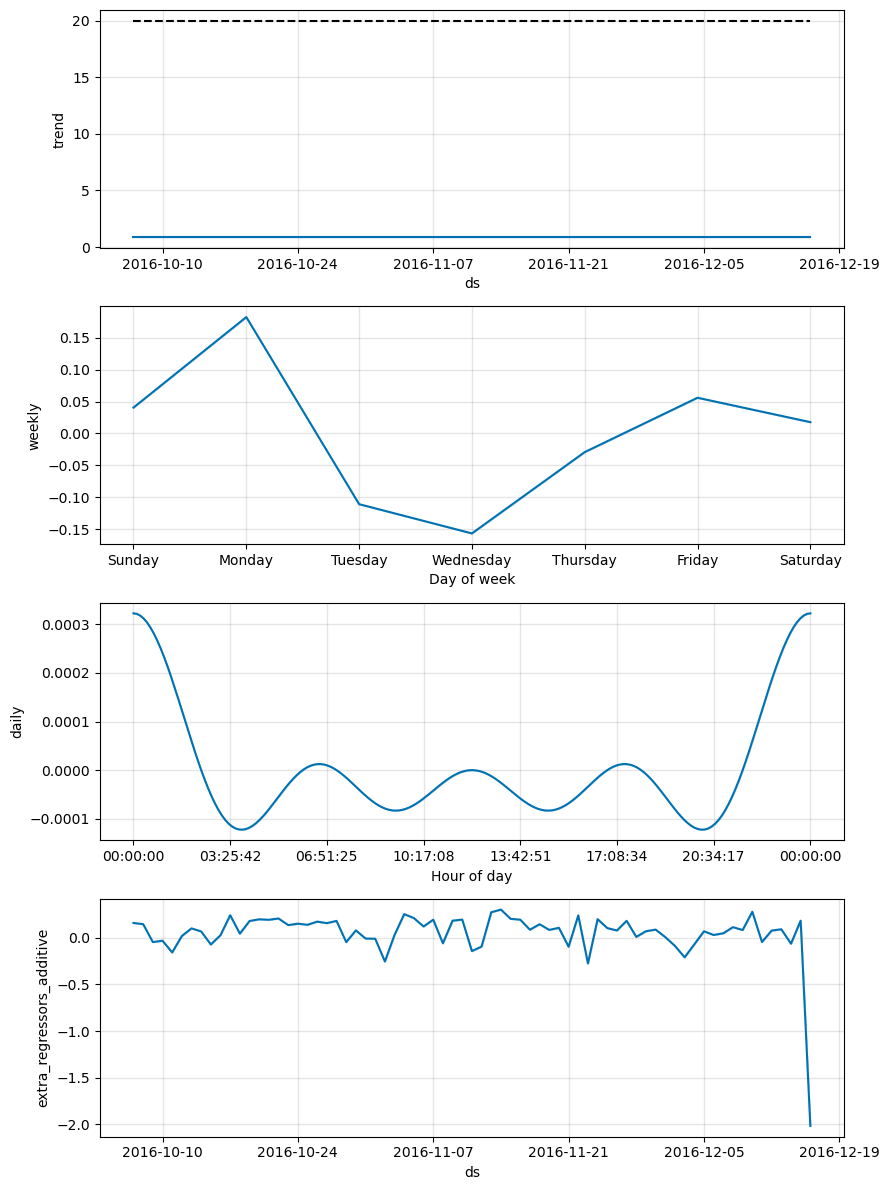

,MAE,MSE,RMSE,R2,MAPE
0,0.263592,0.168427,0.410399,-2.430969,37.415923


In [14]:
prophet,prophet_prediction_metrics = prophet_model(transformed_data_daily, y='use',
                                                        regressors=daily_regressors)
display(prophet_prediction_metrics)

19:01:00 - cmdstanpy - INFO - Chain [1] start processing
19:01:00 - cmdstanpy - INFO - Chain [1] done processing


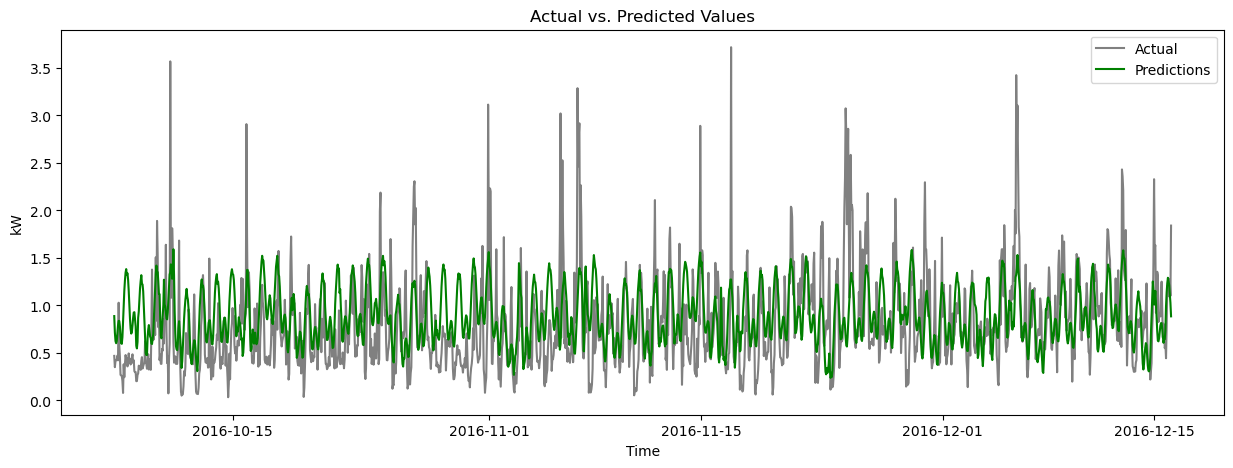

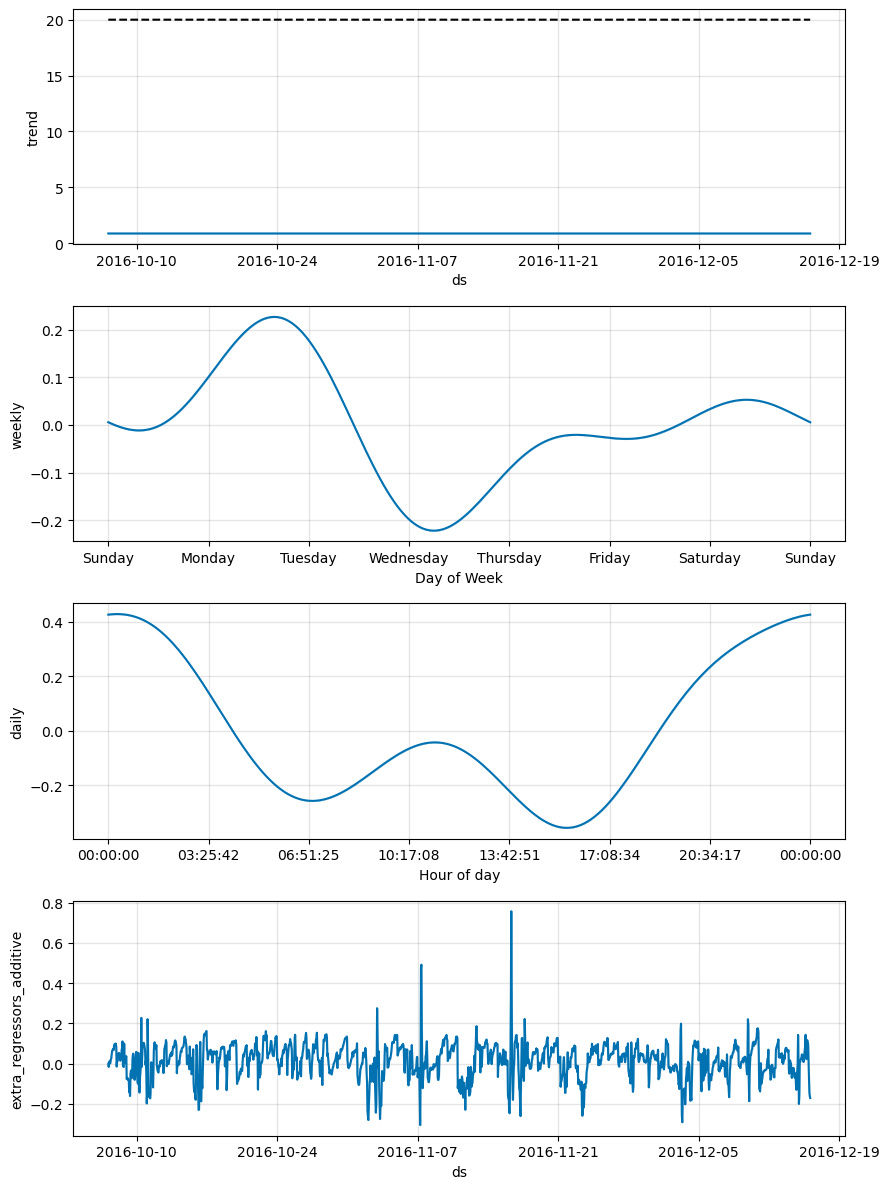

,MAE,MSE,RMSE,R2,MAPE
0,0.34076,0.203302,0.45089,0.120875,71.380419


In [15]:
prophet,prophet_prediction_metrics = prophet_model(transformed_data_hourly, y='use',
                                                        regressors=hourly_regressors)
display(prophet_prediction_metrics)

>**Parameters**
>* *growth="flat", weekly_seasonality=True, daily_seasonality=True, changepoint_range = 0.9, changepoint_prior_scale=0.5, seasonality_prior_scale=15*
>
>**Observations**
> * Logistic and linear parameters exhibited a decreasing trend that didn't match the actual value, leaving only a flat trend in proximity.
> * The trend doesn't seem to fit the one observed during EDA, and the impact of the regressors isn't helping the model to follow the underlying patterns of the data.
>


### *Long Short Term Memory*

> The LSTM (Long Short-Term Memory) model is a type of recurrent neural network (RNN) known for its ability to learn long-term dependencies in sequential data. Unlike traditional RNNs, which may struggle to remember information over long time periods due to the vanishing gradient problem, LSTMs are designed with specialized memory units that enable them to retain and recall information over extended periods. I'm considering using it due to its predictive capability in time series data.

Epoch 1/60
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0641
Epoch 2/60
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3998
Epoch 3/60
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3716
Epoch 4/60
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3492
Epoch 5/60
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3117
Epoch 6/60
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3107
Epoch 7/60
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2723
Epoch 8/60
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2934
Epoch 9/60
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2970
Epoch 10/60
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3127
Epoch 11/60
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2842
Epoch 12/60
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3112
Epoch 13/60
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2600
Epoch 14/60
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2549
Epoch 15/60
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - lo

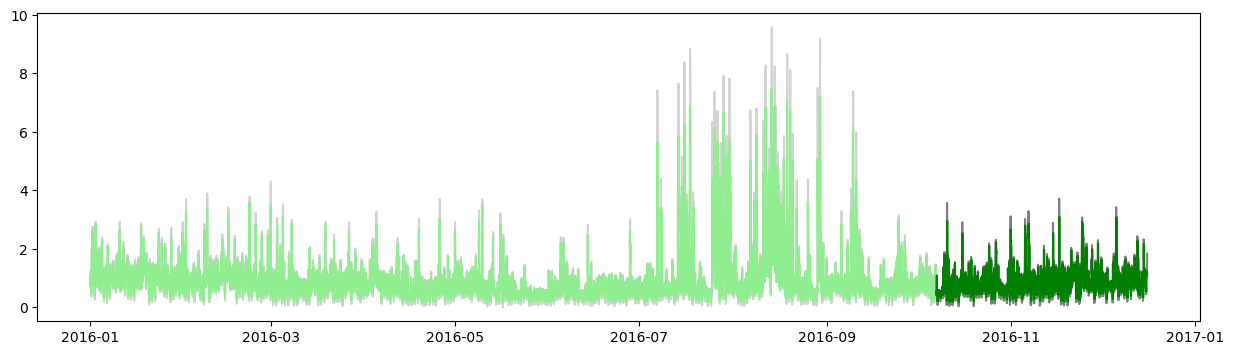

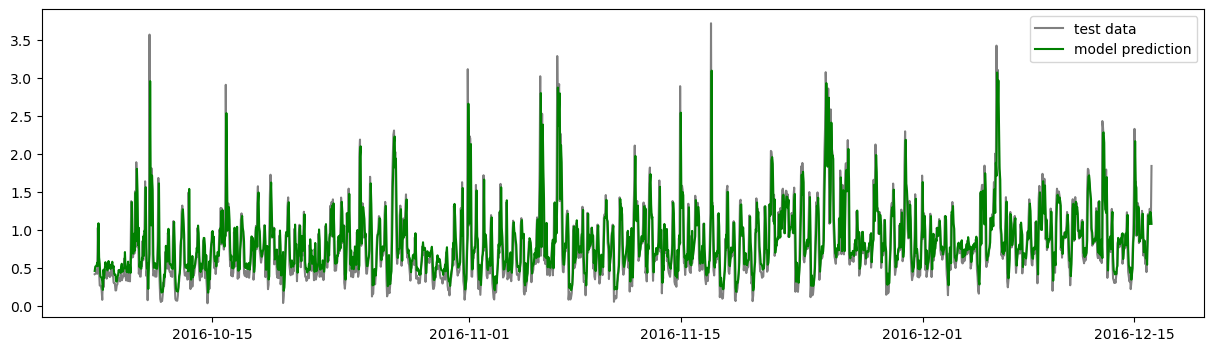

MSE: 0.11966
RMSE: 0.34591
MAE: 0.230
MAPE: 0.942
R^2 score: 0.483


In [16]:
lstm_implementation_pipeline(use_data_hourly, 2, train_size=0.80, lstm_units=30, activation='relu', optimizer='adam', loss='mse', epochs=60, verbose=1)

> In this case, the model achieved a moderate R^2 score of 0.500, suggesting that approximately 50% of the variance in the dependent variable is explained by the model. These metrics indicate a moderate level of accuracy, suggesting that the model captures a significant portion of the variability in the data. However, there is room for improvement, particularly considering the relatively high MAPE value of 0.876, indicating a relatively high percentage error in the predictions.
>
> I intend to incorporate relevant meteorological variables along with features like the day of the month and hour, as this will enhance the model's ability to capture external factors influencing energy consumption patterns. 

## **Multivariate Time-Series Prediction**

### *Long Short Term Memory Multivariate*

In [17]:
lstm_use_data_hourly = data[["use", "visibility","pressure","precipprobability",'humidity','windspeed', 
                    'cloudcover', 'windbearing', 'precipintensity',"hour","day", "temperature", "dewpoint"]]
lstm_use_data_hourly = lstm_use_data_hourly.resample('h').mean()

Epoch 1/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 84.6030
Epoch 2/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.0696
Epoch 3/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2515
Epoch 4/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2129
Epoch 5/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0697
Epoch 6/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9295
Epoch 7/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7062
Epoch 8/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7000
Epoch 9/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7256
Epoch 10/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5805
Epoch 11/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5617
Epoch 12/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5032
Epoch 13/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4843
Epoch 14/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4922
Epoch 15/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 

,MSE,RMSE,MAE,MAPE,R^2 Score
0,0.021808,0.147675,0.114538,0.286537,0.926717


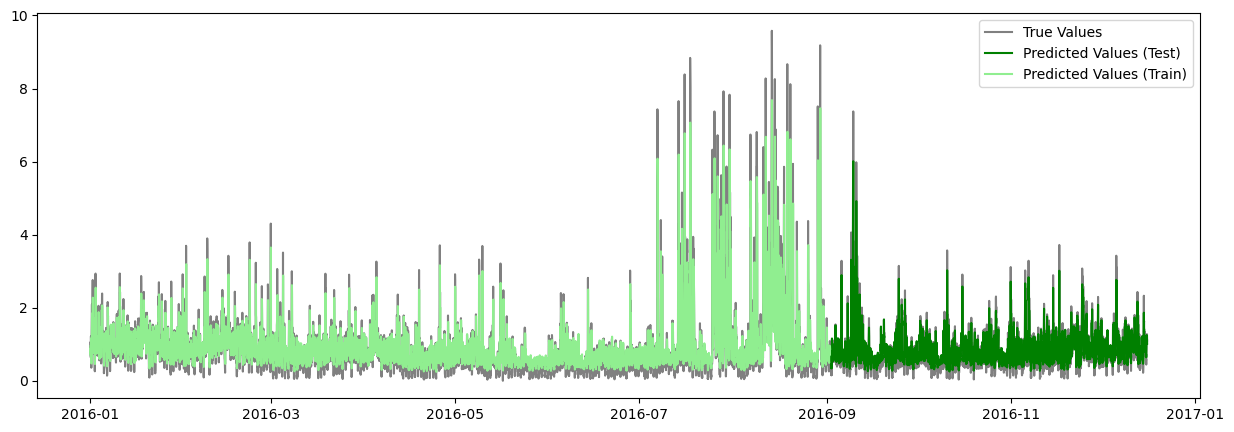

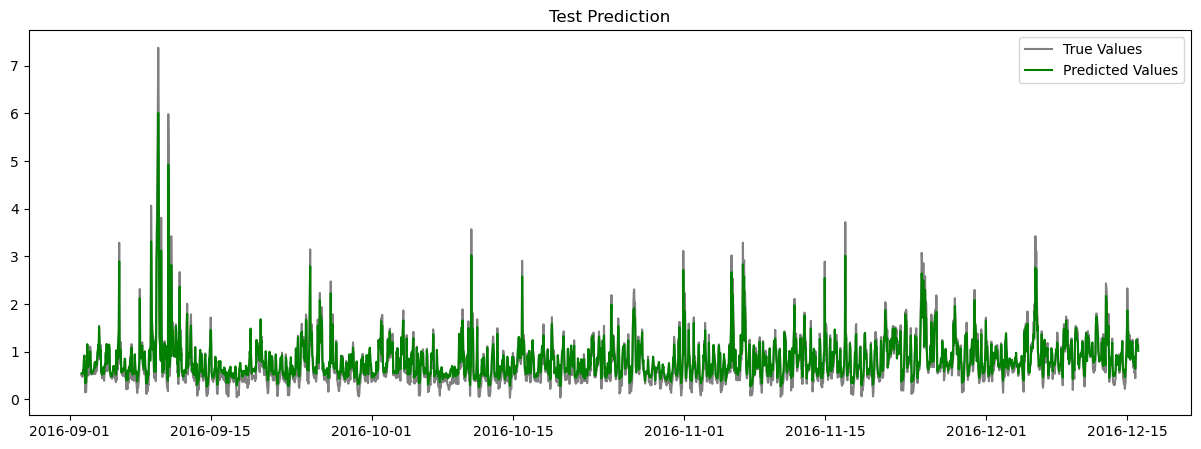

In [18]:
predictions, model, metrics = lstm_multivariate_implementation_pipeline(lstm_use_data_hourly, n_past=1, n_future=1, epochs=100, verbose=1)
metrics

> With a mean squared error (MSE) of 0.018512, root mean squared error (RMSE) of 0.136057, mean absolute error (MAE) of 0.093032, mean absolute percentage error (MAPE) of 0.196557, and an R-squared score of 0.937794, the model demonstrates a high level of accuracy in forecasting energy consumption. This suggests that the inclusion of these additional variables has effectively captured relevant external factors influencing energy usage patterns, leading to enhanced predictive capabilities and better overall model performance.

## **Anomaly Detection**

> Given the nuanced patterns observed in energy consumption, particularly the presence of outliers during peak usage periods, it's interesting to implement robust anomaly detection methods. The ChangeFinder model offers a promising solution, as it specializes in detecting abrupt changes in time series data called changepoints. By applying this model, I aim to proactively identify unusual consumption behaviors that would lead to optimize energy usage and to unnecesary expenditure prevention.

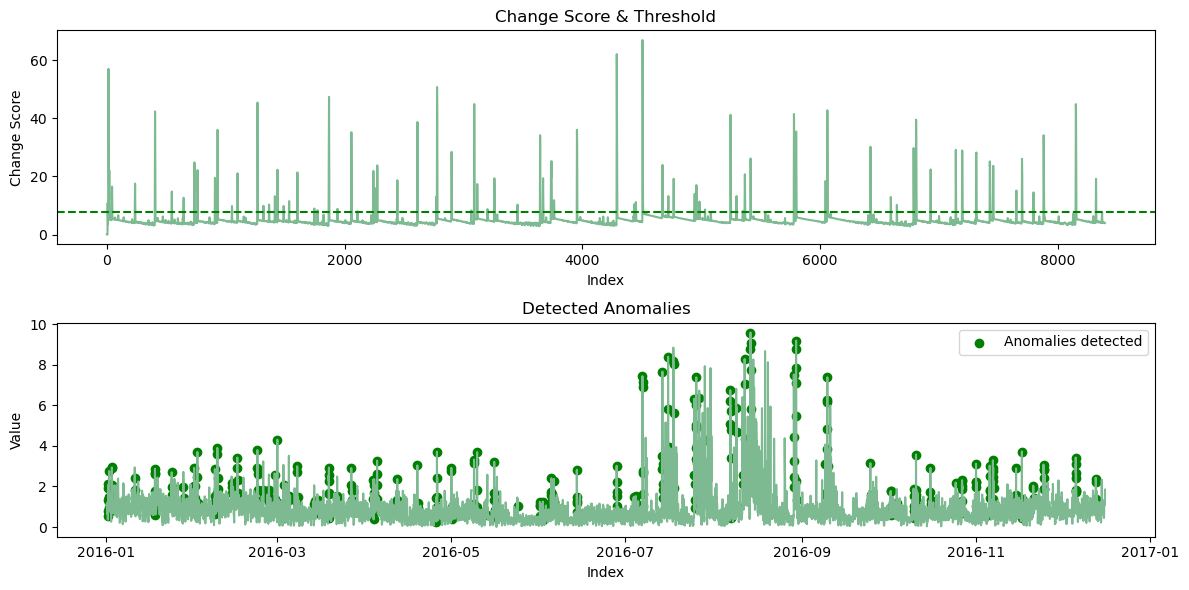

In [19]:
changepoints_df = anomaly_detector(use_data_hourly, ad_r=0.01, ad_order=1, ad_smooth=4)

## **Conclusion**

>In conclusion, this project has provided valuable insights into energy consumption patterns and their relationship with meteorological variables. Through data analysis and modeling techniques, we have identified the impact of outliers on overall consumption and proposed proactive measures for optimization. Leveraging LSTM networks, and anomaly detection with the ChangeFinder model, we've successfully developed predictive models capable of capturing complex consumption behaviors and external influences.
>
>Moving forward, these findings pave the way for more efficient energy management strategies, enabling stakeholders to make informed decisions and drive tangible cost savings. By integrating anomaly detection algorithms into real-time monitoring systems, we can proactively identify irregular consumption patterns, mitigate wastage, and optimize resource allocation. Also, ongoing refinement and iteration based on insights gained from continuous data analysis will ensure the sustainability and effectiveness of our energy optimization efforts.
>
>Ultimately, this project underscores the power of data-driven approaches in shaping a more sustainable and efficient future, where smart energy management plays a crucial role in mitigating environmental impact and driving economic efficiency.

#### *Dashboard Exportation*

In [20]:
#Export the model for deployment
file_path = r"C:\Users\angel\Desktop\Data Analysis\Ironhack\Final Bootcamp Project\Smart-Home-Energy-Consumption-Project\models"
save_model(model,file_path)

Model saved successfully to 'C:\Users\angel\Desktop\Data Analysis\Ironhack\Final Bootcamp Project\Smart-Home-Energy-Consumption-Project\models\model.pkl'.


In [23]:
data["use_outlier"] = 0
data.loc[data["use"] > 1.5, "use_outlier"] = 1
data.head()

,use,gen,dishwasher,home office,fridge,wine cellar,garage door,barn,well,microwave,living room,temperature,humidity,visibility,apparenttemperature,pressure,windspeed,cloudcover,windbearing,precipintensity,dewpoint,precipprobability,furnace,kitchen,month,day,weekday,hour,minute,gen_outlier,use_outlier
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01 05:00:00,0.932833,0.003483,0.000033,0.442633,0.124150,0.006983,0.013083,0.031350,0.001017,0.004067,0.001517,36.14,0.62,10.0,29.26,1016.91,9.18,0.75,282.0,0.0,24.4,0.0,0.082617,0.000567,1,1,Friday,5,0,0,0
2016-01-01 05:01:00,0.934333,0.003467,0.000000,0.444067,0.124000,0.006983,0.013117,0.031500,0.001017,0.004067,0.001650,36.14,0.62,10.0,29.26,1016.91,9.18,0.75,282.0,0.0,24.4,0.0,0.084533,0.000567,1,1,Friday,5,1,0,0
2016-01-01 05:02:00,0.931817,0.003467,0.000017,0.446067,0.123533,0.006983,0.013083,0.031517,0.001000,0.004067,0.001650,36.14,0.62,10.0,29.26,1016.91,9.18,0.75,282.0,0.0,24.4,0.0,0.083017,0.000617,1,1,Friday,5,2,0,0
2016-01-01 05:03:00,1.022050,0.003483,0.000017,0.446583,0.123133,0.006983,0.013000,0.031500,0.001017,0.004067,0.001617,36.14,0.62,10.0,29.26,1016.91,9.18,0.75,282.0,0.0,24.4,0.0,0.175417,0.000650,1,1,Friday,5,3,0,0
2016-01-01 05:04:00,1.139400,0.003467,0.000133,0.446533,0.122850,0.006850,0.012783,0.031500,0.001017,0.004067,0.001583,36.14,0.62,10.0,29.26,1016.91,9.18,0.75,282.0,0.0,24.4,0.0,0.300917,0.000783,1,1,Friday,5,4,0,0


In [24]:
changepoints_df

,Date
0,2016-01-01 11:00:00
1,2016-01-01 12:00:00
2,2016-01-01 16:00:00
3,2016-01-01 17:00:00
4,2016-01-01 18:00:00
...,...
385,2016-12-06 02:00:00
386,2016-12-12 22:00:00
387,2016-12-12 23:00:00
388,2016-12-13 00:00:00


In [25]:
predictions

time
2016-09-02 04:00:00    0.541603
2016-09-02 05:00:00    0.545384
2016-09-02 06:00:00    0.534927
2016-09-02 07:00:00    0.544133
2016-09-02 08:00:00    0.609019
                         ...   
2016-12-15 22:00:00    1.251135
2016-12-15 23:00:00    1.149173
2016-12-16 00:00:00    1.153348
2016-12-16 01:00:00    1.140080
2016-12-16 02:00:00    1.016846
Freq: H, Length: 2519, dtype: float32